In [121]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd

## Question 1 & 2 & Extra credit

In [122]:
import scipy

def pm_first_component(M) :

    d = M.shape[1]
    x = np.ones(d) / np.sqrt(d)

    while True :
        Mx = M.dot(x)
        new_x = Mx / np.linalg.norm(Mx)
        if np.allclose(x, new_x, atol=0.1): 
            break   
        x = new_x
    
    return x

def pm_second_component(M) :
    first = pm_first_component(M)
    # factor the first domninant component out of the data
    Q, R = np.linalg.qr(M)
    beta = scipy.linalg.solve_triangular(R, Q.T.dot(first))
    first_proj = Q.T.dot(M)
    M_factored = M - first_proj
    # now the most dominant component will be the second dim
    return pm_first_component(M_factored)

In [135]:
A = np.array([[4,5, 10, 20],
              [6,8, 11, 15],
              [2, 6, 14, 17],
              [4,8, 11, 14]])
dom_v = pm_first_component(A)
dom2_v = pm_second_component(A)

In [136]:
dom_v, dom2_v

(array([0.5, 0.5, 0.5, 0.5]),
 array([0.84740879, 0.1498136 , 0.40537207, 0.30842781]))

****
## Question 3 : Gradient Descent vs SVD for PCA transformation

> Gradient Descent is faster and computationally cheaper than SVD.
> 
> Gradient Descent is a convex optimization method whereas SVD is not.
>
> Gradient Descent is an empirical method for solving PCA whereas SVD is more of an analytical method.
>
> Gradient Descent tries to solve PCA by optimising the trainable parameters $W$ and $Z$ with respect to the cost function $J(W,Z) = ||ZW - X||^{2}_{F}$. SVD tries to solve PCA by decomposing the matrix $M = U \Sigma V$. SVD is computationally expensive because it consists of finding:
>
> > Eigenvalues and eigenvectors of $MM^{T}$ and $M^{T}M$.
> >
> > Eigenvectors of $MM^{T}$ that make up the columns of $U$.
> >
> > Eigenvectors of $M^{T}M$ that make up the columns of $V$. 
> 
> Gradient descent complexity depends on $n$, the number of examples in the dataset. SVD complexity depends on $p$, the number of features in the dataset, which are used to find the covariance matrix. So, in the case of $p > n$, gradient descent is faster and less expensive.

****
## Question 4 : One vs One, One vs Rest

In [125]:
from sklearn.linear_model import LogisticRegression
import itertools
import numpy as np

class multi_class:
    
    def __init__(self, mode='ovr'):
        if mode not in ['ovo', 'ovr'] : 
            print("Only two modes available, 'ovo' & 'ovr'.\nDefaulting to 'ovr'.")
            mode = 'ovr'
        self.mode = mode
        self.clfs = {'ovr' : {},
                     'ovo' : {}}
    
    def fit(self,X, Y):
        
        if self.mode == 'ovr':
            """
                For each class c
                    - c is positive example, rest is negative example
                    - train a binary classifier for the subset
            """
            for c in np.unique(Y):
                new_lbls = [1 if y == c else -1 for y in Y]
                clf = LogisticRegression()
                clf.fit(X, new_lbls)

                self.clfs['ovr'][str(c)] = clf
        elif self.mode == 'ovo':
            """
                For each pair of classes (n * [(n-1)/2])
                    - train a binary classifier for the new subset which only has 
                      the two classes
            """
            combos = list(itertools.combinations(np.unique(Y), 2))
            for c in combos :
                idx = list()
                for i in range(len(Y)) :
                    if Y[i] in c : idx.append(i)
                sub_X = X[idx, :]
                sub_Y = Y[idx]
                clf = LogisticRegression()
                clf.fit(sub_X, sub_Y)
                c_name = str(c[0]) + '_' + str(c[1])
                self.clfs['ovo'][c_name] = clf
        
    def predict(self,X):
        if self.mode == 'ovr':
            clfs = self.clfs['ovr']
            preds = np.zeros((len(X), len(clfs.keys())))
            for c in clfs.keys():
                preds[:,int(c)] = clfs[c].predict(X)
            y_hat = np.argmax(preds, axis=1)
            return y_hat 
        elif self.mode == 'ovo' :
            clfs = self.clfs['ovo']
            preds = np.zeros((len(clfs.keys()), len(X)))
            for i, clf in enumerate(clfs.values()) :
                preds[i, :] = clf.predict(X)
            preds = preds.astype('int64')
            y_hat = [np.bincount(preds[:, i]).argmax() for i in range(len(X))]
            return y_hat

In [126]:
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.33,
                                                    random_state=42)

In [127]:
ovr = multi_class(mode='ovr')

In [128]:
ovr.fit(train_X, train_Y)

In [129]:
y_hat = ovr.predict(test_X)

In [130]:
from sklearn.metrics import accuracy_score

print('The score is {}'.format(accuracy_score(test_Y, y_hat)))

The score is 0.7


In [131]:
ovo = multi_class(mode='ovo')

In [132]:
ovo.fit(train_X, train_Y)

In [133]:
preds = ovo.predict(test_X)

In [134]:
print('The score is {}'.format(accuracy_score(test_Y, preds)))

The score is 1.0


****
## Question 5 : Overfitting & Underfitting

> Overfitting occurs when a model has learnt the training data so well that it faults when it sees some new data.
>
> Underfitting occurs when a model has not learnt the training data as well as it should.
>
> Overfitting can be spotted by looking at the accuracy score on the training and test data. The accuracy score on the training data will be excellent when a model has overfit but the test score will be poor.
>
> In the case of Underfitting, the accuracy score on both the training and the test data will be low.
>
> During overfitting, the model learns the noise of the training data. 

#### Generate some data :

In [17]:
# Make up some data

def truth(x): return np.cos(0.5* x * np.pi*1.5)**2
sample_size = 150

X = np.sort(np.random.randn(sample_size))
X = X.reshape(-1,1)
Y = truth(X).ravel()

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

## Underfitting

***
***

> We are setting some limitations on the decision tree and the svm models.
>
> For the decision tree model : 
>
>> `max_depth = 2`
>>
>> `max_leaf_nodes = 2`
>>
>> This ensures that our DT model won't be able to train its parameters fully so it will lead to an underfit model.
>
> For the svm model :
>
>> `kernel = linear`
>>
>> `gamma = 1`
>>
>> We know that our y values follows cosine function, which is not linear. So setting the `kernel` as *linear* ensures that the svm model underfits.

In [19]:
tree = DecisionTreeRegressor(max_depth=2, random_state=42, max_leaf_nodes=2)
svm = SVR(kernel='linear', degree=1, gamma=1)

In [20]:
tree.fit(X, Y)
svm.fit(X, Y)

SVR(degree=1, gamma=1, kernel='linear')

In [21]:
test_X = np.sort(np.random.randn(sample_size)).reshape(-1,1)
test_Y = truth(test_X).ravel()
tree_preds = tree.predict(test_X)
svm_preds = svm.predict(test_X)

In [22]:
tree_train_preds = tree.predict(X)
svm_train_preds = svm.predict(X)

print("Decision Tree :\n Train RSME score : {0:.6f}\n Test RSME score : {1:.6f}".format(mse(Y, tree_train_preds, squared=False),
                                                                                       mse(test_Y, tree_preds, squared=False)))

print("SVM Model :\n Train RSME score : {0:.6f}\n Test RSME score : {1:.6f}".format(mse(Y, svm_train_preds, squared=False),
                                                                                   mse(test_Y, svm_preds, squared=False)))

Decision Tree :
 Train RSME score : 0.359559
 Test RSME score : 0.342607
SVM Model :
 Train RSME score : 0.371907
 Test RSME score : 0.343075


> The evaluation metric used in this example is the *Root Mean Squared Error*. 
> 
>> $RMSE = \sqrt{\frac{\sum_{i=1}^{N} (\hat{y}_{i}- y_{i})^{2}}{N}}$
>>
>> where, $y_{i}$ is the observed value for $i_{th}$ observation, $\hat{y}_{i}$ is the predicted value and N is the number of observatios.
>
> A perfect fit of the model is denoted by lower $RMSE$ score. 
>
> For a model to be underfit, both the training and testing scores should be bad. 
>
> For both the DT and SVM model, the training and testing scores are around the same and are bad.
>
> How do we know they are bad ? Let's take a look at the plots below.

### Decision Tree

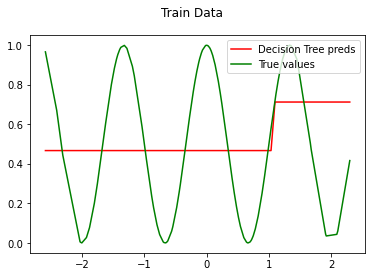

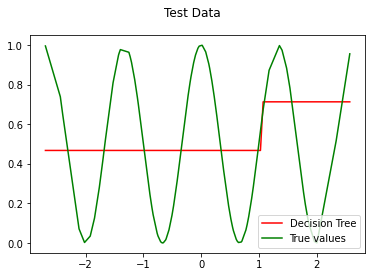

In [23]:
plt.plot(X, tree_train_preds, 'r', label = 'Decision Tree preds')
plt.plot(X, Y, 'g', label="True values")
plt.legend(loc="best")
plt.suptitle("Train Data")
plt.show()
plt.plot(test_X, tree_preds, 'r', label="Decision Tree")
plt.plot(test_X, test_Y, 'g', label="True values")
plt.legend(loc="best")
plt.suptitle("Test Data")
plt.show()

> It is clear from the plots that our model does not do well. 
>
> The actual values, denoted in green, follows cosine function. The predicted values, denoted in red, clearly are not following cosine function.
>
> Both the training and testing predictions are pretty bad.
>
> Hence, the DT model has underfit the data.

### Support Vector Machine

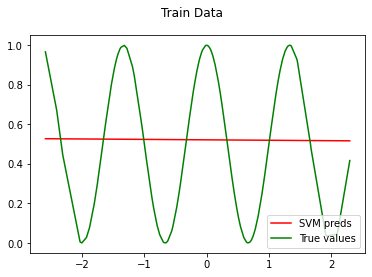

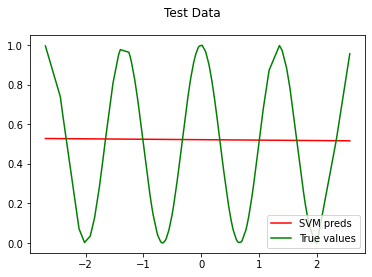

In [24]:
plt.plot(X, svm_train_preds, 'r', label="SVM preds")
plt.plot(X, Y, 'g', label="True values")
plt.suptitle("Train Data")
plt.legend(loc="best")
plt.show()
plt.plot(test_X, svm_preds, 'r', label="SVM preds")
plt.plot(test_X, test_Y, 'g', label="True values")
plt.legend(loc="best")
plt.suptitle("Test Data")
plt.show()

> Again, the predicted values do not match the actual values at all.
>
> We can see that the SVM model predicted values which are linear. This is because we specified the kernel as linear.
>
> The model has underfit the data.

## Overfitting

***
***

> To make the model overfit dataset, we have to set the parameters to the other extreme. We want the model to understand the training data so well that it even understands and learns the noise in the dataset.
> For the Decision Tree model,
>
>> `max_depth = 100`
>>
>> `max_leaf_nodes = 100`
>>
>> This will ensure that the trees grow to full extent and understand our data well.
>
> For the SVM model,
>
>> `kernel = "rbf"`
>> 
>> `gamma = 150`
>>
>> Using *Radial Basis Function* kernel ensures that it learns the non-linear changes in the data and fits it properly. The **gamma** value is picked so that overfitting can be achieved.

In [31]:
tree = DecisionTreeRegressor(max_depth=100, random_state=42, max_leaf_nodes=100)
svm = SVR(kernel='rbf', gamma=175)

In [32]:
tree.fit(X, Y)
svm.fit(X, Y)

SVR(gamma=175)

In [33]:
tree_preds = tree.predict(test_X)
svm_preds = svm.predict(test_X)

In [34]:
tree_train_preds = tree.predict(X)
svm_train_preds = svm.predict(X)

print("Decision Tree :\n Train RSME score : {0:.6f}\n Test RSME score : {1:.6f}".format(mse(Y, tree_train_preds, squared=False),
                                                                                       mse(test_Y, tree_preds, squared=False)))

print("SVM Model :\n Train RSME score : {0:.6f}\n Test RSME score : {1:.6f}".format(mse(Y, svm_train_preds, squared=False),
                                                                                   mse(test_Y, svm_preds, squared=False)))

Decision Tree :
 Train RSME score : 0.001891
 Test RSME score : 0.064908
SVM Model :
 Train RSME score : 0.091515
 Test RSME score : 0.121047


> As we can see, the $RSME$ on the test data is greater than the $RSME$ on the train data for both the models.
>
> So our models performed better on the training data but couldn't perform the same or even better on data that it hadn't seen before.
>
> This is a classic indication of overfitting.

### Decision Tree

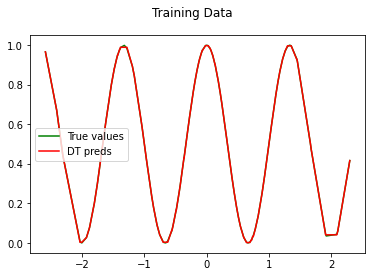

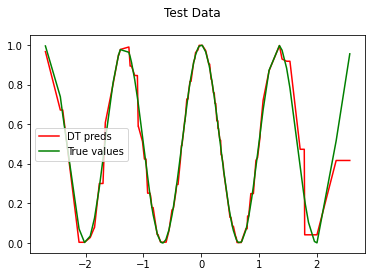

In [35]:
plt.plot(X, Y, 'g', label="True values")
plt.plot(X, tree_train_preds, 'r', label="DT preds")
plt.suptitle("Training Data")
plt.legend(loc="best")
plt.show()
plt.plot(test_X, tree_preds, 'r', label="DT preds")
plt.plot(test_X, truth(test_X), 'g', label="True values")
plt.suptitle("Test Data")
plt.legend(loc="best")
plt.show()

> The predictions and the actual values on the train data are on point which is why we are not able to see the green color of the true values.
>
> The DT model has done an excellent job of learning the training data.
>
> In the next plot however, we can see where the predictions differ from the actual values. So our DT model hasn't generalised the learnings enough to understand the new data.

### Support Vector Machine

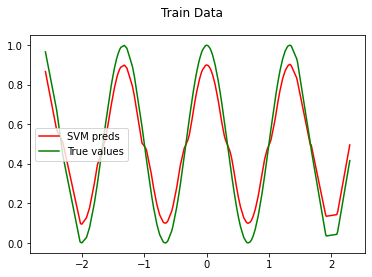

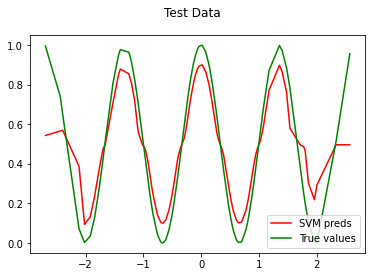

In [36]:
plt.plot(X, svm_train_preds, 'r', label="SVM preds")
plt.plot(X, Y, 'g', label="True values")
plt.suptitle("Train Data")
plt.legend(loc='best')
plt.show()
plt.plot(test_X, svm_preds, 'r', label="SVM preds")
plt.plot(test_X, truth(test_X), 'g', label="True values")
plt.suptitle("Test Data")
plt.legend(loc="best")
plt.show()

> The SVM model hasn't learnt the training data as well as the DT model has. But the predictions closely follow the actual values on the training data.
>
> On the test data however, we can see a lot more deviations between the predicted and the actual values. 
>
> This tells us that more work needs to be done to help the model understand the patterns better.

***
## Question 6 : Kernel Vs Polynomial features

> The kernel procedures are used to map data to higher dimensional space in order to help models to learn non linear function or decision boundary.
>
> Polynomial features transformation maps the features to a higher dimensional space by raising the existing features to an exponent.
>
> Polynomial feature transformations usually work well when the exponent or degree $d$ is between $2$ $-$ $4$. Over that, the curve becomes overly flexible and can take some complex shapes.
>
> When kernel procedures map the input data to higher dimensional space, it tries to find a linear decision function in the higher dimensional space which translates to non-linear decision function in the original input space. 
>
> Polynomial features transformation generates new features. So it is recommended to use it when the number of features is less. We do not want too many features generated as it increases the complexity and the possibility of overfitting.
>
> Kernel methods calculate the dot product and not the feature vector. It is due to this fact that kernel methods or "trick" are efficient to compute. The feature vectors can be infinite dimensional and if we were to compute them it can be computationally expensive. 

In [149]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import time

X, y = load_iris(return_X_y=True)
poly_features = PolynomialFeatures(degree=4)
train_poly = time.process_time()
transformed_X = poly_features.fit_transform(X)
train_X, test_X, train_Y, test_Y = train_test_split(transformed_X, y, 
                                                    test_size=0.33,
                                                    random_state=42)
poly_clf = LogisticRegression()
poly_clf.fit(train_X, train_Y)
print("Classifier Training took {0:.3f} processor time".format(time.process_time() - train_poly))
test_poly = time.process_time()
yhat = poly_clf.predict(test_X)
print("Classifier Prediction took {0:.3f} processor time".format(time.process_time() - test_poly))

Classifier Training took 0.040 processor time
Classifier Prediction took 0.000 processor time


/home/rohit/anaconda3/envs/A3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [150]:
train_X, test_X, train_Y, test_Y = train_test_split(X, y, 
                                                    test_size=0.33,
                                                    random_state=42)
clf = SVC(kernel='rbf')
train_time = time.process_time()
clf.fit(train_X, train_Y)
print("Classifier Training took {0:.3f} processor time".format(time.process_time() - train_time))
test_time = time.process_time()
yhat = clf.predict(test_X)
print("Classifier Prediction took {0:.3f} processor time".format(time.process_time() - test_time))

Classifier Training took 0.002 processor time
Classifier Prediction took 0.001 processor time


> The polynomial features transform along with Logistic Regression took 0.040 seconds to train and 0.000 seconds to predict while SVM with the rbf kernel took 0.002 seconds to train and 0.001 seconds to predict.
> 
> The difference may look small, but for a bigger dataset it can get quite big.
>
> The kernel procedures are faster than polynomial features transform because all the computations in the kernel are done using dot products.

****

## Question 7 : Grid Search Kernels and Parameters

In [73]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.svm import SVC

def grid_search_svc(X, Y):
    
    def rbf_clf(gamma) : return SVC(kernel='rbf', gamma=gamma)
    def poly_clf(degree) : return SVC(kernel='poly', degree=degree)
    def sig_clf(c) : return SVC(kernel='sigmoid', C=c)
    
    kf = StratifiedKFold(n_splits=3)
    gammas = [0.0001, 0.001, 0.01, 0.05, 0.1, 1, 10, 100, 1000]
    degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    c_s = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 100000]
    std_sc_gamma = -1
    std_sc_deg = -1
    best_kernel = {'kernel' : None,
                   'param_name' : None,
                   'param' : None,
                   'std_f1' : -1}
    kernel_params = {'rbf' : {'params' : gammas,
                              'clf' : rbf_clf,
                              'std_f1_param' : -1,
                              'std_param' : None,
                              'param_name' : 'gamma'
                             },
                     'poly' : {'params' : degrees,
                               'clf' : poly_clf,
                               'std_f1_param' : -1,
                               'std_param' : None,
                               'param_name' : 'degree'
                              },
                     'sigmoid' : {'params' : c_s,
                                  'clf' : sig_clf,
                                  'std_f1_param' : -1,
                                  'std_param' : None,
                                  'param_name' : 'C'
                                 }
                    }
    split_num = 0
    for train_idx, test_idx in kf.split(X, Y):
        x_train, x_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]
        
        for tr_id, te_id in kf.split(x_train, y_train):
            x_tr, x_te = x_train.iloc[tr_id], x_train.iloc[te_id]
            y_tr, y_te = y_train.iloc[tr_id], y_train.iloc[te_id]
            
            # estimating kernels and params
            for kernel in kernel_params.keys():
                for param in kernel_params[kernel]['params']:
                    svm = kernel_params[kernel]['clf'](param)
                    svm.fit(x_tr, y_tr)
                    yhat = svm.predict(x_te)
                    f1 = f1_score(y_te, yhat, average="weighted")
                    if f1 > kernel_params[kernel]['std_f1_param']:
                        kernel_params[kernel]['std_f1_param'] = f1
                        kernel_params[kernel]['std_param'] = param
        print('================ Model Evaluation after {0} split =================='.format(split_num))
        for kernel in kernel_params.keys():
            svm = kernel_params[kernel]['clf'](kernel_params[kernel]['std_param'])
            svm.fit(x_train, y_train)
            yhat = svm.predict(x_test)
            f1 = f1_score(y_test, yhat, average='weighted')
            print('==========================================')
            print('SVM model with {0} kernel and {1} {2}'.format(kernel, 
                                                                 kernel_params[kernel]['param_name'],
                                                                 kernel_params[kernel]['std_param']))
            print('F1 score : {0:.3f}'.format(f1))
            # best kernel estimation
            if f1 > best_kernel['std_f1'] : 
                best_kernel['kernel'] = kernel
                best_kernel['param_name'] = kernel_params[kernel]['param_name']
                best_kernel['param'] = kernel_params[kernel]['std_param']
                best_kernel['std_f1'] = f1
        print('==============================================================================')
        
        split_num += 1
    return best_kernel

In [74]:
X, Y = load_iris(as_frame=True, return_X_y=True)

grid_search_svc(X, Y)

================ Model Evaluation after 0 split ==================
SVM model with rbf kernel and gamma 0.05
F1 score : 0.960
SVM model with poly kernel and degree 1
F1 score : 0.960
SVM model with sigmoid kernel and C 0.001
F1 score : 0.155
================ Model Evaluation after 1 split ==================
SVM model with rbf kernel and gamma 0.05
F1 score : 0.980
SVM model with poly kernel and degree 1
F1 score : 0.980
SVM model with sigmoid kernel and C 5
F1 score : 0.167
================ Model Evaluation after 2 split ==================
SVM model with rbf kernel and gamma 0.05
F1 score : 0.940
SVM model with poly kernel and degree 1
F1 score : 0.960
SVM model with sigmoid kernel and C 5
F1 score : 0.060


{'kernel': 'rbf',
 'param_name': 'gamma',
 'param': 0.05,
 'std_f1': 0.979963133640553}

***
## Question 8 : Kernels

### Graph Kernel

> Graphs are natural data structures which model objects and their relationships.
>
> Fields such as bioinformatics. chemoinformatics, drug discovery, web data mining and social networks involves study of relationships between structured objects. 
>
> Graphs are used to model such structures. The nodes represent objects and the edges represent the relations between them. 
>
> For machine learning tasks such as classification and clustering, two questions are often encountered,
> 
>> *How similar are two nodes in a given graph*
>>
>> *How similar are two graphs to each other*
>
> Such questions require a special approach to solve within agreeable computation limits. This is where graph kernel comes in.
>
> Kernel methods are an obvious answer to the above questions because a kernel is a measure of similarity between objects.
>
> An example of graph kernel application is in protein function prediction. Consider the question, *Is this protein an enzyme or not ?*  To answer this, we need to infer the protein function by finding proteins with similar sequence, structure or chemical properties. One way to do this is to model the protein as a graph and assign similar functions to similar graphs. Graph kernels are used here to measure the similarity between proteins and enzymes.

### String Kernel

> String kernels compute the similarity between strings.
>
> A common string kernel is the substring kernel. It captures the matching substrings within two strings. The kernel function is :
> 
>> $$ K_{k, \delta}(s, t) = \sum_{i=0}^{L-k+1} \sum_{d=-\delta}^{\delta} I(s[i : i + k], t[i + d : i + d + k])$$
>>
>> where $I$ is the indicator function, that is $I(u, v)$ = $1$ if $u$ $=$ $v$ otherwise $0$. $k$ is the substring length and $\delta$ is the shift parameter.
>
> For example, 
>
>> Consider the strings 
>> $$u = "ATTGCCATCA"$$ 
>> 
>> $$v = "TTGCCTCATC"$$
>>
>> Consider $k$ $=$ $3$ and $\delta$ $=$ $1$
>>
>> The kernel function output will be 3. 
>>
>> Substring "TTG" is present in both the $u$ and $v$. It starts at position 1 in $u$ and in position 0 in $v$, $\delta$ of $1$
>> 
>> Substring "GCC" starts at position 3 in $u$ and in position 2 in $v$.
>>
>> Substring "CAT" starts at position 5 in $u$ and in position 6 in $v$.

### Sigmoid Kernel

> The sigmoid kernel is widely used for classification tasks.
>
> The kernel function is 
>
>> $$ K(X, Y) = tanh(\alpha . X^{T} Y + c) $$
>>
>> where $X$ is the features and $Y$ is the target. $\alpha$ is the usually set to $\frac{1}{N}$ where $N$ is the data dimension. $c$ is the kernel parameter and is the slope of the intercept.